# CNN 무작정 연습해보기 : MNIST

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchsummary import summary

## 데이터셋 불러오기

- 데이터셋 다운로드

In [2]:
training_dataset = datasets.MNIST(root='dataset',
                                  train=True,
                                  download=True,
                                  transform=ToTensor(),
                                  )

test_dataset = datasets.MNIST(root='dataset',
                              train=False,
                              download=False,
                              transform=ToTensor(),
                              )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 30259173.66it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2509908.08it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14489216.50it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8089396.50it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



- 각 변수에 데이터셋이 담겨있는 상태

In [3]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

## 데이터셋 구경하기

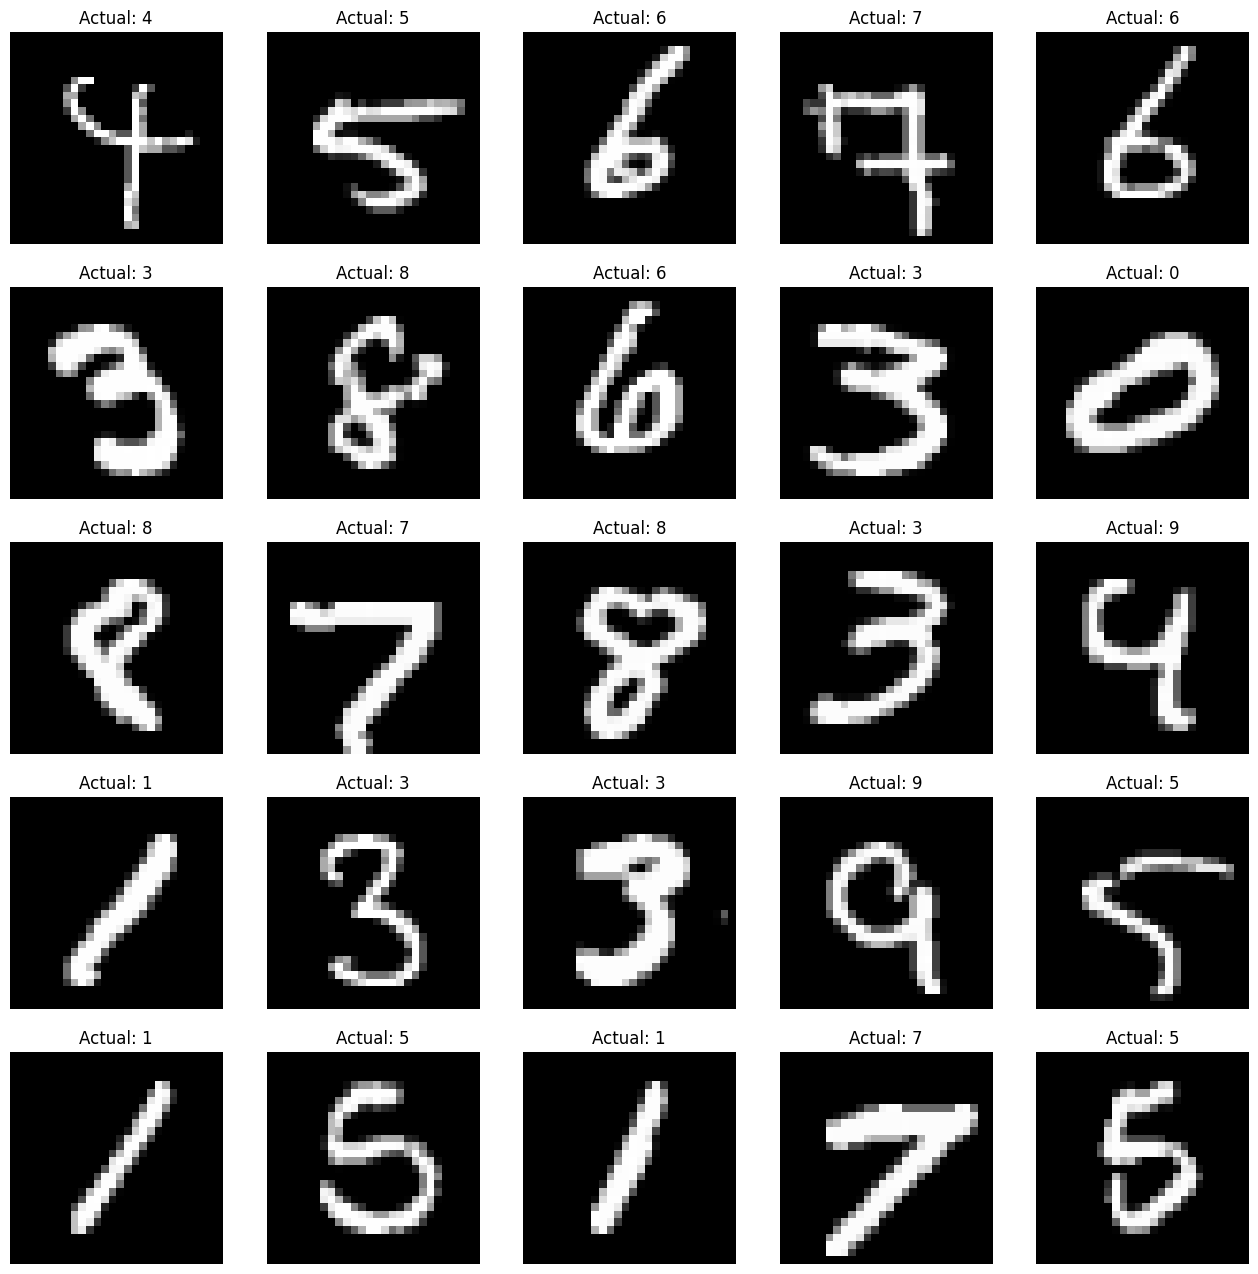

In [5]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]

    plt.title(f'Actual: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## 데이터로더 생성하기
- 데이터셋을 순차적으로 조회 가능하도록 만드는 작업

In [6]:
batch_size = 32

train_dataloader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size
                             )

In [7]:
for x, y in train_dataloader :
    print(f'학습 데이터의 형태 [N, C, H, W] : {x.shape}')
    print(f'학습 데이터의 데이터 타입: {x.dtype}')

    print(f'정답 데이터의 형태 : {y.shape}')
    print(f'정답 데이터의 데이터 타입: {y.dtype}')
    break

학습 데이터의 형태 [N, C, H, W] : torch.Size([32, 1, 28, 28])
학습 데이터의 데이터 타입: torch.float32
정답 데이터의 형태 : torch.Size([32])
정답 데이터의 데이터 타입: torch.int64


## 연산 장치 설정

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f'연산 장치 : {device}')

연산 장치 : cpu


## 모델 정의 및 생성

- 모델의 형태 구성

In [9]:
class BasicCNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.basicCNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128,
                      kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(7*7*64, 256)  # 입력 크기를 수정함
        )

    def forward(self, x) :
        x = self.basicCNN(x)
        return x

In [10]:
model = BasicCNN().to(device)
model

BasicCNN(
  (basicCNN): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=256, bias=True)
  )
)

In [11]:
from torchsummary import summary

In [12]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
         MaxPool2d-3          [-1, 128, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          73,792
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
Total params: 878,144
Trainable params: 878,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.96
Params size (MB): 3.35
Estimated Total Size (MB): 5.32
----------------------------------------------------------------


- 손실 함수와 옵티마이저 설정

In [13]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
loss_fn

CrossEntropyLoss()

In [15]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

- 학습 절차를 함수화

In [16]:
def train(dataloader, model, loss_fn, optim) :
    model.train()
    size = len(dataloader.dataset)

    for batch, (x, y) in enumerate(dataloader) :
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch % 100 == 0 :
            loss = loss.item()
            current = (batch+1) * len(x)
            print(f'[{current:5d}/{size:5d}] | loss: {loss:.4f}')

In [17]:
def test(dataloader, model, loss_fn) :
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for x, y in dataloader :
            x, y = x.to(device), y.to(device)

            y_pred = model(x)
            test_loss = test_loss + loss_fn(y_pred, y).item()
            correct = correct + (y_pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss = test_loss / num_batches
    correct = correct / size

    print(f'Accuracy: {100*correct:.2f}% | Avg_loss: {test_loss:.4f}')

In [18]:
epochs = 1

for e in range(epochs) :
    print(f'Epoch {e+1}')
    print('--------------------------')

    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
    print('--------------------------')

print('==============================')
print('End')

Epoch 1
--------------------------
[   32/60000] | loss: 5.6034
[ 3232/60000] | loss: 0.4801
[ 6432/60000] | loss: 0.1173
[ 9632/60000] | loss: 0.1553
[12832/60000] | loss: 0.0549
[16032/60000] | loss: 0.1107
[19232/60000] | loss: 0.0168
[22432/60000] | loss: 0.0362
[25632/60000] | loss: 0.1339
[28832/60000] | loss: 0.0706
[32032/60000] | loss: 0.1281
[35232/60000] | loss: 0.0786
[38432/60000] | loss: 0.1724
[41632/60000] | loss: 0.1525
[44832/60000] | loss: 0.0288
[48032/60000] | loss: 0.1186
[51232/60000] | loss: 0.1081
[54432/60000] | loss: 0.0037
[57632/60000] | loss: 0.0745
Accuracy: 97.18% | Avg_loss: 0.0824
--------------------------
End


## 테스트 결과 살펴보기

In [19]:
model.eval()

rand_idx = torch.randint(0, 10000, size=(1,)).item()
x, y = test_dataset[rand_idx][0].view((-1,1,28,28)), test_dataset[rand_idx][1]

with torch.no_grad() :
    x = x.to(device)
    y_pred = model(x)

    predicted = y_pred.argmax()
    actual = y

    print(f'Predicted: {predicted} | Actual: {actual}')

Predicted: 8 | Actual: 8


- 시각화 하여 살펴보기

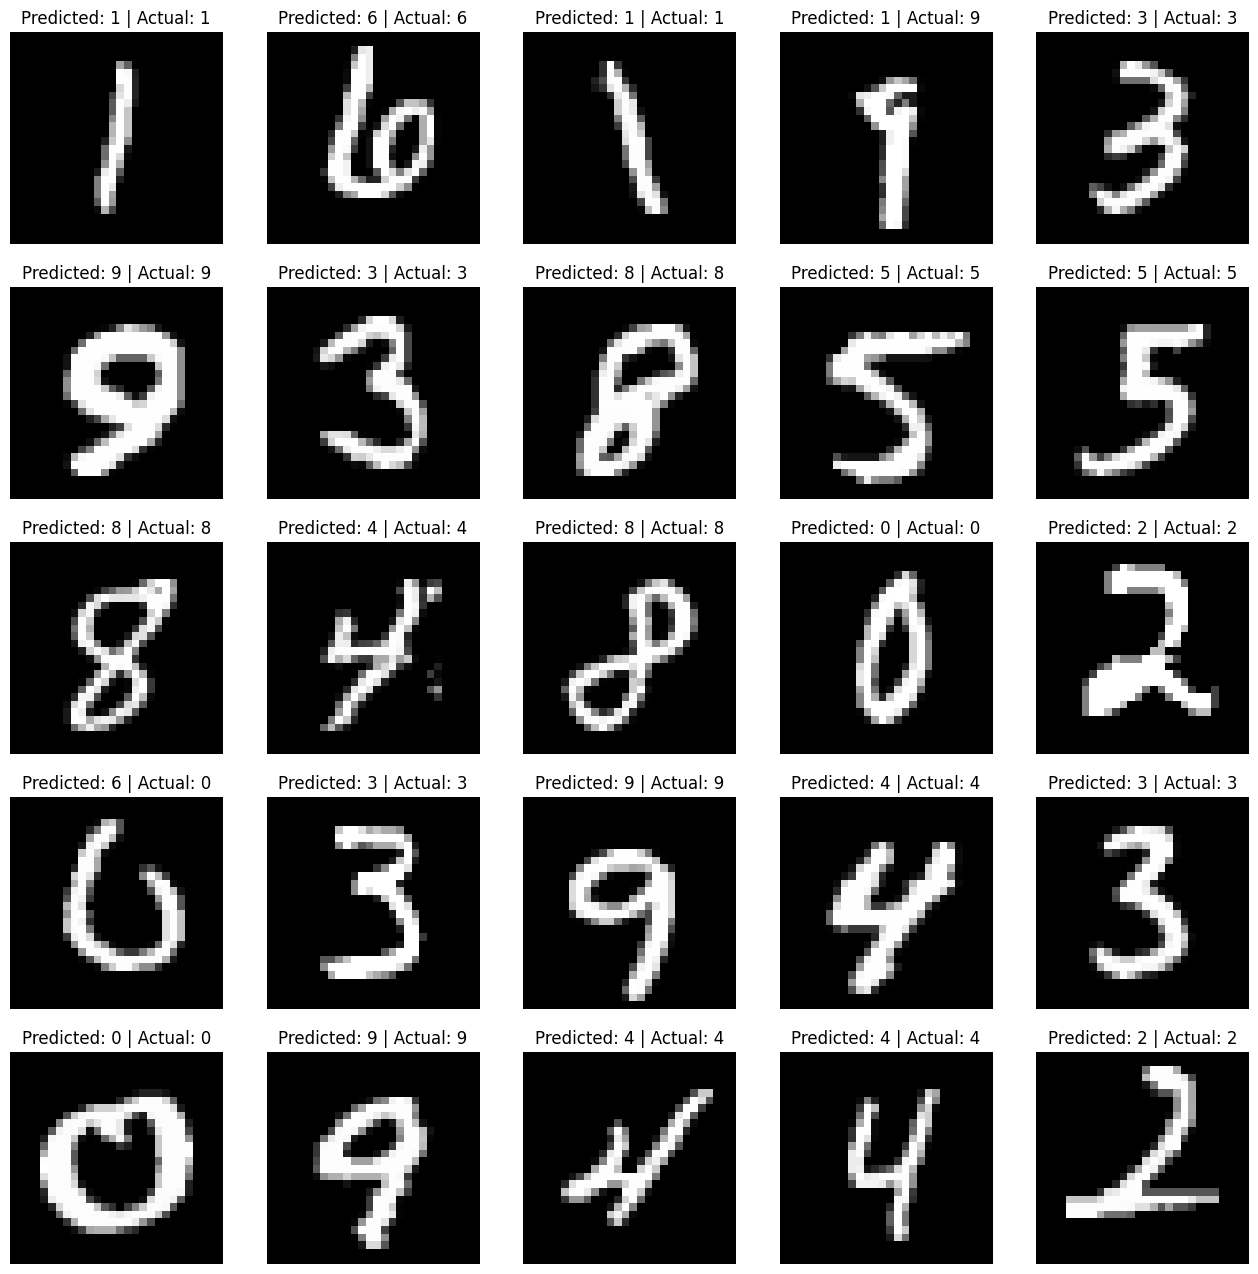

In [20]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    rand_idx = torch.randint(0, 10000, size=(1,)).item()
    x, y = test_dataset[rand_idx][0].view((-1,1,28,28)), test_dataset[rand_idx][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax()
        actual = y

    plt.title(f'Predicted: {predicted} | Actual: {actual}')
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")

plt.show()

- 틀린 것만 시각화 하여 살펴보기

In [21]:
model.eval()

predicted_list, actual_list = [], []

for i in range(len(test_dataset)) :
    x, y = test_dataset[i][0].view((-1,1,28,28)), test_dataset[i][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax().item()
        actual = y

        predicted_list.append(predicted)
        actual_list.append(actual)

In [22]:
predicted_list[:5], actual_list[:5]

([7, 2, 1, 0, 4], [7, 2, 1, 0, 4])

In [23]:
false_idx_list = []

for i in range(len(predicted_list)) :
    if predicted_list[i] != actual_list[i] :
        false_idx_list.append(i)

false_idx_list[:5]

[18, 62, 217, 316, 320]

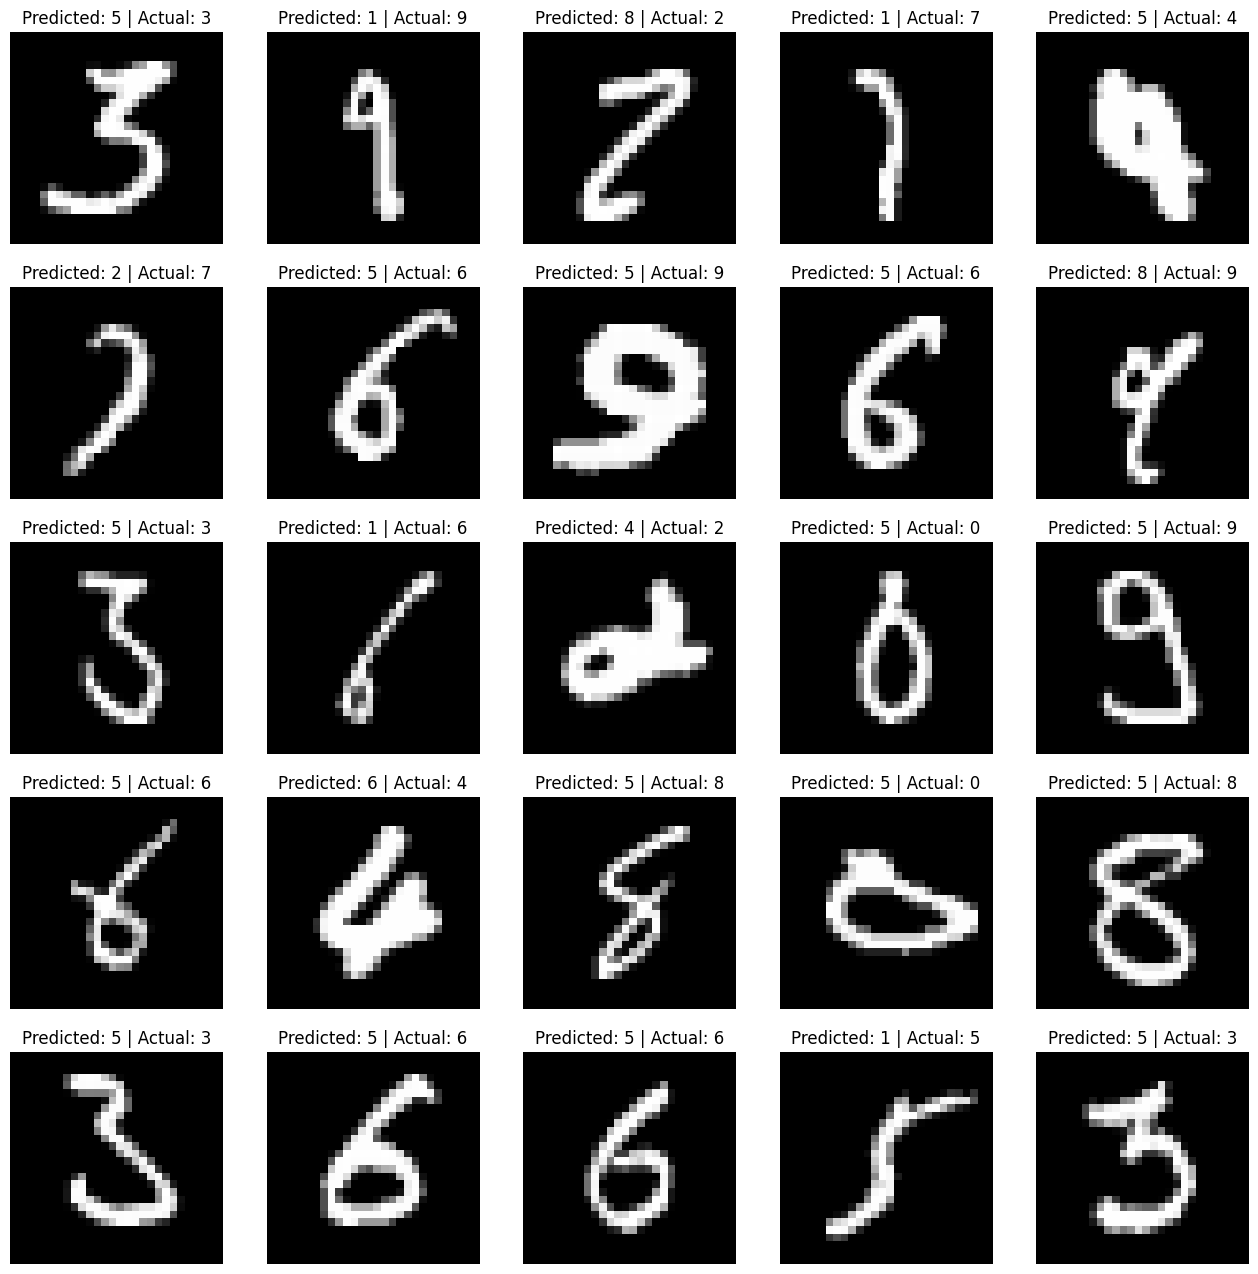

In [24]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = false_idx_list[ torch.randint(len(false_idx_list), size=(1,)).item() ]

    with torch.no_grad() :
        temp_x = test_dataset[ sample_idx ][0].view((-1,1,28,28))
        temp_y_pred = model(temp_x)

        temp_predicted = temp_y_pred.argmax().item()
        temp_actual = test_dataset[ sample_idx ][1]

    plt.title(f'Predicted: {temp_predicted} | Actual: {temp_actual}')
    plt.axis("off")
    plt.imshow(temp_x.squeeze(), cmap="gray")

plt.show()

## **내가 쓴 숫자도 인식할까?**
---
## **구글 드라이브에 손글씨 이미지를 업로드!**
###**순서**
1. 그림판으로 숫자를 그려서 저장한다. (저장할 때, 숫자를 파일명 맨 앞에 명시하는 것을 권장! ex) 3.png, 3_1.png )
2. 구글 드라이브 첫 화면에 my_data 라는 폴더를 만든다.
3. my_data 폴더 안에 my_mnist 폴더를 만든다.
4. my_mnist 폴더 안에 1번 과정에서 만든 이미지를 업로드한다.
5. 30초 정도 기다립시다.
6. 아래의 코드들을 실행해본다.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import glob

In [27]:
data_path = glob.glob('/content/drive/MyDrive/my_data/my_mnist/*')
data_path

[]

In [28]:
mydata_y = []

for image_file in data_path :
    # print(path[40:41])
    mydata_y.append(int(image_file[40:41]))

In [29]:
mydata_y_ts = torch.tensor(mydata_y, dtype=torch.long)

In [30]:
from PIL import Image
from torchvision.transforms import PILToTensor

In [31]:
mydata_x = []

for image_file in data_path :
    temp = Image.open(image_file)
    temp = temp.resize((28,28))
    temp = temp.convert('L')
    temp = PILToTensor()(temp)
    temp = temp.type(torch.float32)
    # print(temp.dtype)
    mydata_x.append(temp)

In [32]:
mydata_x_ts = torch.stack(mydata_x)
mydata_x_ts.shape

RuntimeError: stack expects a non-empty TensorList

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
mydataset = TensorDataset(mydata_x_ts, mydata_y_ts)

In [ ]:
for x, y in mydataset :
    print(x)
    print(y)
    break

In [ ]:
mydataset[0][0].shape

In [ ]:
mydataset[0][1].item()

In [ ]:
# for i in range(30) :
#     print(mydataset[i][0].dtype)
#     print(mydataset[i][1].dtype)

In [ ]:
model.eval()

for i in range(40) :
    temp_x, temp_y = mydataset[i][0].view((-1,1,28,28)), mydataset[i][1]

    with torch.no_grad() :
        temp_x = temp_x.to(device)
        y_pred = model(temp_x)

        predicted = y_pred.argmax()
        actual = temp_y

        print(f'Predicted: {predicted} | Actual: {actual}')

In [ ]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 8

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    x, y = mydataset[i-1][0].view((-1,1,28,28)), mydataset[i-1][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax()
        actual = y

    plt.title(f'Predicted: {predicted} | Actual: {actual}')
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")

plt.show()